In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt

In [2]:
input_fname = 'test_toymodel.in'
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 2**10
dTune = 2

In [3]:
import sys
old_stdout = sys.stdout
log_file   = open("log."+str(dTune),"w")
sys.stdout = log_file

In [4]:
def getArgLostLive(TBTdata,rad):
    dummy,iLost = np.where(np.sqrt(TBTdata[:,0,:]**2+TBTdata[:,2,:]**2)>rad)
    iLost = set(iLost)
    iLive = set(np.arange(npt))
    iLive = iLive - iLost
    iLost=np.array(list(iLost))
    iLive=np.array(list(iLive))
    return iLost,iLive

### 1. read InputFile and simplify lattice

In [5]:
beam, lattice = impact.readInputFile(input_fname);
beam.nCore_y = 8
beam.nCore_z = 4
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
lattice[0].turns = 2*nTurn
betx = beam.distribution.betx
alfx = beam.distribution.betx

In [6]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[2].tune_advance = 0.01*dTune

### 2. generate particles

In [7]:
testP = 0.0
sig = 0.01
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
for i in np.arange(-(nx-1)/2.0,(nx-1)/2.0+0.5):
    for j in np.arange(-(nx-1)/2.0,(nx-1)/2.0+0.5):
        x=2.0*i*sig/nx
        y=2.0*j*sig/nx
        if x**2+y**2<=sig**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])

pTest = np.array(pTest)
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
impact.writeParticleData(pTest, ke, mass, freq)

npt = len(pTest)
beam.n_particles = npt
print('initial npt=',npt)

# FMA

In [8]:
print('===========================')
print('=========== FMA ===========')
print('===========================')

In [9]:
TBT = impact.getElem('TBToutput_multi_particles')
TBT.file_id = dTune
lattice.insert(1,TBT)
impact.writeInputFile(beam,lattice) 
impact.run(beam)
indexTBT,TBTdataTmp = impact.readTBT(dTune,ke,mass,freq)
pDataOut= impact.readParticleData(111111,ke,mass,freq)
pDataIn = impact.readParticleData(111110,ke,mass,freq)

In [10]:
iLost,iLive = getArgLostLive(TBTdataTmp,rad=2.0*sig*np.sqrt(2.0))
nptLive = len(iLive)
nptLost = len(iLost)
TBTdata = TBTdataTmp[:,:,iLive]
print('TBTdata.shape =',TBTdata.shape)
print('nptLost,nptLive =',nptLost,nptLive)

In [11]:
X = TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:])
Y = TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:])
tune1 = np.zeros([2,nptLive])
tune2 = np.zeros([2,nptLive])
tune3 = np.zeros([2,nptLive])
for i in range(nptLive):
    tune1[0,i],amp = impact.util.naff(1,X[:nTurn,i],window_id=1)
    tune1[1,i],amp = impact.util.naff(1,Y[:nTurn,i],window_id=1)
    tune2[0,i],amp = impact.util.naff(1,X[nTurn:,i],window_id=1)
    tune2[1,i],amp = impact.util.naff(1,Y[nTurn:,i],window_id=1)
    tune3[0,i],amp = impact.util.naff(1,X[:,i],window_id=1)
    tune3[1,i],amp = impact.util.naff(1,Y[:,i],window_id=1)

In [12]:
Xdiff = np.abs(tune2[0,:]-tune1[0,:])
Ydiff = np.abs(tune2[1,:]-tune1[1,:])
Adiff = np.sqrt(Xdiff**2 + Ydiff**2)
print('max(Xdiff)',np.max(Xdiff))
print('max(Ydiff)',np.max(Ydiff))
print('max(Adiff)',np.max(Adiff))
Adiff = np.log(Adiff+1.0e-6)
Xdiff = np.log(Xdiff+1.0e-6)
Ydiff = np.log(Ydiff+1.0e-6)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

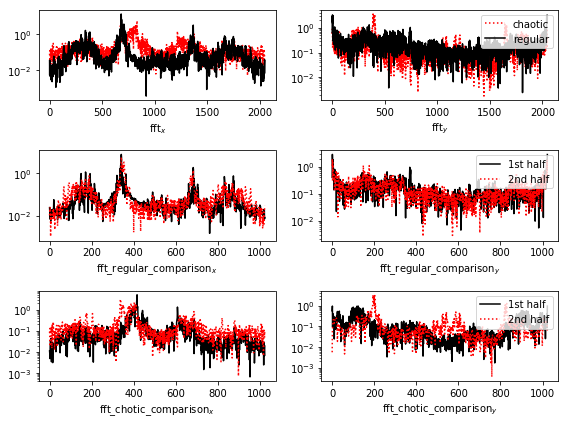

In [13]:
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[:,iMaxX])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[:,iMinX])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[:,iMaxY])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[:,iMinY])),'k')
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMinX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn:,iMinX])),'r:')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMinY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn:,iMinY])),'r:')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMaxX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn:,iMaxX])),'r:')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMaxY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn:,iMaxY])),'r:')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FFT.'+str(dTune)+'.png',dpi=180)

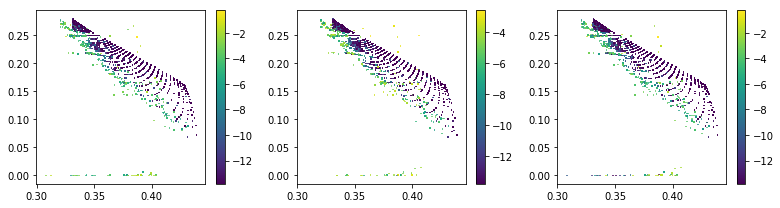

In [14]:
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(tune3[0,:],tune3[1,:],c=Adiff,s=0.2,marker='s')
plt.colorbar(f1)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.subplot(1,3,2)
f2=plt.scatter(tune3[0,:],tune3[1,:],c=Xdiff,s=0.2,marker='s')
plt.colorbar(f2)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.subplot(1,3,3)
f3=plt.scatter(tune3[0,:],tune3[1,:],c=Ydiff,s=0.2,marker='s')
plt.colorbar(f3)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.tight_layout()
plt.savefig('FMA.'+str(dTune)+'.png',dpi=180)

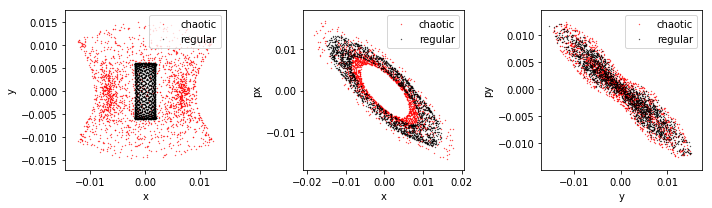

In [15]:
plt.figure(figsize=[10,3])
plt.subplot(1,3,1)
plt.scatter(TBTdata [:,0,iMaxA],TBTdata [:,2,iMaxA],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinA],TBTdata [:,2,iMinA],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
# plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,2)
plt.scatter(TBTdata [:,0,iMaxX],TBTdata [:,1,iMaxX],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinX],TBTdata [:,1,iMinX],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,3)
plt.scatter(TBTdata [:,2,iMaxY],TBTdata [:,3,iMaxY],c='r',s=0.1)
plt.scatter(TBTdata [:,2,iMinY],TBTdata [:,3,iMinY],c='k',s=0.1)
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('y')
plt.ylabel('py')
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.tight_layout()
plt.savefig('Poincare.FMA.'+str(dTune)+'.png',dpi=180)

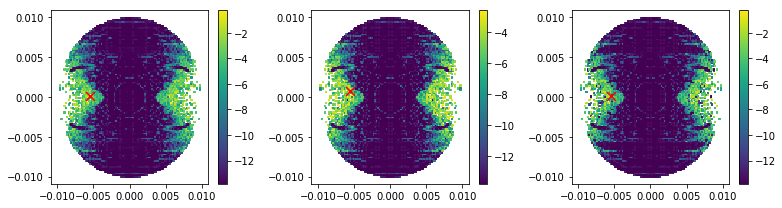

In [16]:
xmax = np.max([TBTdata[0,0,:],TBTdata[0,2,:]])
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Adiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxA],TBTdata[0,2,iMaxA],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f1)
plt.subplot(1,3,2)
f2=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Xdiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxX],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f2)
plt.subplot(1,3,3)
f3=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Ydiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxY],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f3)
plt.tight_layout()
plt.savefig('DA.FMA.'+str(dTune)+'.png',dpi=180)

### Invariants FMA

In [17]:
pDataRegularWorst = np.zeros([1,9])
pDataRegularBest  = np.zeros([1,9])
pDataRegularWorst[0,:6] = TBTdata[0,:,iMaxA]
pDataRegularBest [0,:6] = TBTdata[0,:,iMinA]
pDataRegularWorst[0,6:] = pTest[0,6:]
pDataRegularBest [0,6:] = pTest[0,6:]

In [18]:
latticeI = copy(lattice)
latticeI.pop(1)
beamI = copy(beam)
beamI.nCore_y = 1
beamI.nCore_z = 1
beamI.n_particles = 1
impact.writeInputFile(beamI,latticeI) 
impact.writeParticleData(pDataRegularWorst, ke, mass, freq)
impact.run()
impact.writeParticleData(pDataRegularBest, ke, mass, freq)
fort81Worst = np.loadtxt('fort.81')
impact.run()
fort81Best = np.loadtxt('fort.81')

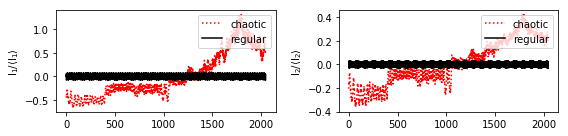

In [19]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(fort81Worst[:,1]/np.mean(fort81Worst[:,1])-1.0,'r:')
plt.plot(fort81Best [:,1]/np.mean(fort81Best [:,1])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.plot(fort81Worst[:,2]/np.mean(fort81Worst[:,2])-1.0,'r:')
plt.plot(fort81Best [:,2]/np.mean(fort81Best [:,2])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('Invariant.FMA.'+str(dTune)+'.png',dpi=180)

# Backward

In [20]:
print('===========================')
print('======== Backward =========')
print('===========================')

In [21]:
pTest = np.zeros([nptLive,9])
for i in range(nptLive):
    pTest[i,:6] = TBTdata[nTurn,:6,i]
    pTest[i,8] = iLive[i]+1 #i+1
pTest[:,6] = q_m
impact.writeParticleData(pTest, ke, mass, freq)

In [22]:
latticeB = copy(lattice[::-1])
latticeB.insert(0,copy(lattice[0]))
latticeB.pop()
latticeB.pop()
latticeB[0].turns = nTurn

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        latticeB[i].tune_advance =-latticeB[i].tune_advance
        latticeB[i].nonlinear_insert_tuneAdvance =-latticeB[i].nonlinear_insert_tuneAdvance
        latticeB[i].nonlinear_insert_length =-latticeB[i].nonlinear_insert_length

impact.writeInputFile(beam,latticeB)
impact.run(beam)

0

In [23]:
pDataMid = impact.readParticleData(111110,ke,mass,freq)
pDataOut = impact.readParticleData(111111,ke,mass,freq)

In [24]:
np.max(np.abs(np.transpose(pDataMid[:,:6])-TBTdata[nTurn,:6,:]))

1.0408340855860843e-17

In [25]:
print('np.max(np.abs(pDataIn[:,8]-1.0-iLive)) =',np.max(np.abs(pDataIn[iLive,8]-1.0-iLive)))

In [26]:
print('np.max(np.abs(pDataOut[:,8]-1.0-iLive)) =',np.max(np.abs(pDataOut[:,8]-1.0-iLive)))

In [27]:
print('np.max(np.abs(TBTdata[0,:6,:]-np.transpose(pDataIn[iLive,:6]))) =',np.max(np.abs(TBTdata[0,:6,:]-np.transpose(pDataIn[iLive,:6]))))

In [28]:
print('np.max(np.abs(TBTdata[0,:6,:]-np.transpose(pDataOut[:,:6]))) =',np.max(np.abs(TBTdata[0,:6,:]-np.transpose(pDataOut[:,:6]))))

In [29]:
pDataOut= impact.readParticleData(111111,ke,mass,freq)
print('----Berr of 10 particles----')
for i in range(10):
    print('init=',end='')
    print(pDataOut[i,:4])
    print('diff=',end='')
    print(pDataOut[i,:4]-TBTdata[0,:4,i])
print('-----------------------------')

In [30]:
X0 = TBTdata[0,0,:] - 1j*(betx*TBTdata[0,1,:]+alfx*TBTdata[0,0,:])
Y0 = TBTdata[0,2,:] - 1j*(betx*TBTdata[0,3,:]+alfx*TBTdata[0,2,:])
X1 = pDataOut[:,0] - 1j*(betx*pDataOut[:,1]+alfx*pDataOut[:,0])
Y1 = pDataOut[:,2] - 1j*(betx*pDataOut[:,3]+alfx*pDataOut[:,2])

Xdiff = np.abs(X1-X0)
Ydiff = np.abs(Y1-Y0)
Adiff = np.sqrt(Xdiff**2 + Ydiff**2)
print('max(Xdiff)',np.max(Xdiff))
print('max(Ydiff)',np.max(Ydiff))
print('max(Adiff)',np.max(Adiff))
print('min(Xdiff)',np.min(Xdiff))
print('min(Ydiff)',np.min(Ydiff))
print('min(Adiff)',np.min(Adiff))
Adiff = np.log(Adiff+1.0e-15)
Xdiff = np.log(Xdiff+1.0e-15)
Ydiff = np.log(Ydiff+1.0e-15)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

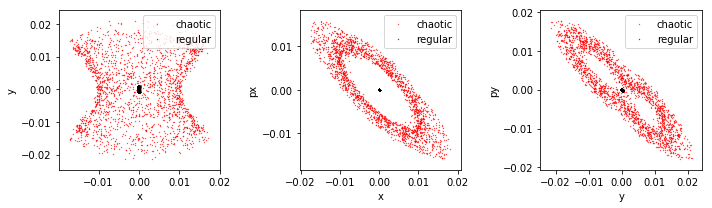

In [31]:
plt.figure(figsize=[10,3])
plt.subplot(1,3,1)
plt.scatter(TBTdata [:,0,iMaxA],TBTdata [:,2,iMaxA],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinA],TBTdata [:,2,iMinA],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
# plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,2)
plt.scatter(TBTdata [:,0,iMaxX],TBTdata [:,1,iMaxX],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinX],TBTdata [:,1,iMinX],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,3)
plt.scatter(TBTdata [:,2,iMaxY],TBTdata [:,3,iMaxY],c='r',s=0.1)
plt.scatter(TBTdata [:,2,iMinY],TBTdata [:,3,iMinY],c='k',s=0.1)
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('y')
plt.ylabel('py')
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.tight_layout()
plt.savefig('Poincare.B.'+str(dTune)+'.png',dpi=180)

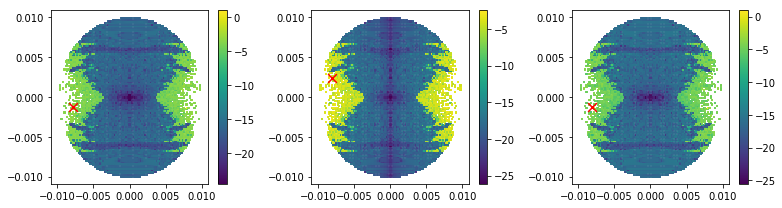

In [32]:
xmax = np.max([TBTdata[0,0,:],TBTdata[0,2,:]])
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Adiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxA],TBTdata[0,2,iMaxA],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f1)
plt.subplot(1,3,2)
f2=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Xdiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxX],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f2)
plt.subplot(1,3,3)
f3=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Ydiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxY],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f3)
plt.tight_layout()
plt.savefig('DA.B.'+str(dTune)+'.png',dpi=180)

### Invariants B

In [33]:
pDataRegularWorst = np.zeros([1,9])
pDataRegularBest  = np.zeros([1,9])
pDataRegularWorst[0,:6] = TBTdata[0,:,iMaxA]
pDataRegularBest [0,:6] = TBTdata[0,:,iMinA]
pDataRegularWorst[0,6:] = pTest[0,6:]
pDataRegularBest [0,6:] = pTest[0,6:]

In [34]:
latticeI = copy(lattice)
latticeI.pop(1)
beamI = copy(beam)
beamI.nCore_y = 1
beamI.nCore_z = 1
beamI.n_particles = 1
impact.writeInputFile(beamI,latticeI) 
impact.writeParticleData(pDataRegularWorst, ke, mass, freq)
impact.run()
impact.writeParticleData(pDataRegularBest, ke, mass, freq)
fort81Worst = np.loadtxt('fort.81')
impact.run()
fort81Best = np.loadtxt('fort.81')

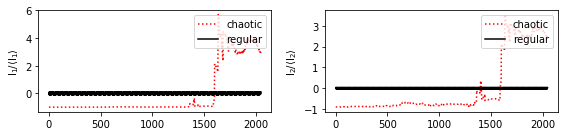

In [35]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(fort81Worst[:,1]/np.mean(fort81Worst[:,1])-1.0,'r:')
plt.plot(fort81Best [:,1]/np.mean(fort81Best [:,1])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.plot(fort81Worst[:,2]/np.mean(fort81Worst[:,2])-1.0,'r:')
plt.plot(fort81Best [:,2]/np.mean(fort81Best [:,2])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('Invariant.B.'+str(dTune)+'.png',dpi=180)

# Foward and Backward

In [36]:
print('===========================')
print('=== Foward and Backward ===')
print('===========================')

In [37]:
pTest = np.zeros([nptLive,9])
for i in range(6):
    pTest[:,i] = TBTdata[nTurn,i,:]
pTest[:,6] = q_m
pTest[:,8] = iLive+1
impact.writeParticleData(pTest, ke, mass, freq)

In [38]:
latticeFB = copy(lattice)
latticeFB = latticeFB + latticeB[1:]
latticeFB[0].turns = nTurn+1
latticeFB[1].file_id = 100 + dTune
impact.writeInputFile(beam,latticeFB)
impact.run(beam)

0

In [39]:
print('----Berr of 10 particles----')
indixTBTFB,TBTdataFB = impact.readTBT(100+dTune,ke,mass,freq)
for i in range(10):
    print('init=',end='')
    print(TBTdataFB[0,:4,i])
    print('diff=',end='')
    print(TBTdataFB[-1,:4,i]-TBTdataFB[0,:4,i])
print('-----------------------------')

In [40]:
X0 = TBTdataFB[0,0,:] - 1j*(betx*TBTdataFB[0,1,:]+alfx*TBTdataFB[0,0,:])
Y0 = TBTdataFB[0,2,:] - 1j*(betx*TBTdataFB[0,3,:]+alfx*TBTdataFB[0,2,:])
X1 = TBTdataFB[-1,0,:] - 1j*(betx*TBTdataFB[-1,1,:]+alfx*TBTdataFB[-1,0,:])
Y1 = TBTdataFB[-1,2,:] - 1j*(betx*TBTdataFB[-1,3,:]+alfx*TBTdataFB[-1,2,:])

Xdiff = np.abs(X1-X0)
Ydiff = np.abs(Y1-Y0)
Adiff = np.sqrt(Xdiff**2 + Ydiff**2)
print('max(Xdiff)',np.max(Xdiff))
print('max(Ydiff)',np.max(Ydiff))
print('max(Adiff)',np.max(Adiff))
print('min(Xdiff)',np.min(Xdiff))
print('min(Ydiff)',np.min(Ydiff))
print('min(Adiff)',np.min(Adiff))
Adiff = np.log(Adiff+1.0e-15)
Xdiff = np.log(Xdiff+1.0e-15)
Ydiff = np.log(Ydiff+1.0e-15)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

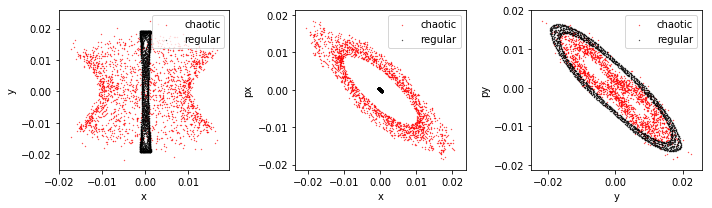

In [41]:
plt.figure(figsize=[10,3])
plt.subplot(1,3,1)
plt.scatter(TBTdata [:,0,iMaxA],TBTdata [:,2,iMaxA],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinA],TBTdata [:,2,iMinA],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
# plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,2)
plt.scatter(TBTdata [:,0,iMaxX],TBTdata [:,1,iMaxX],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinX],TBTdata [:,1,iMinX],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,3)
plt.scatter(TBTdata [:,2,iMaxY],TBTdata [:,3,iMaxY],c='r',s=0.1)
plt.scatter(TBTdata [:,2,iMinY],TBTdata [:,3,iMinY],c='k',s=0.1)
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('y')
plt.ylabel('py')
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.tight_layout()
plt.savefig('Poincare.FB.'+str(dTune)+'.png',dpi=180)

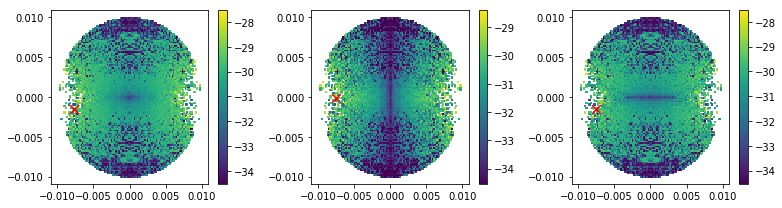

In [42]:
xmax = np.max([TBTdata[0,0,:],TBTdata[0,2,:]])
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Adiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxA],TBTdata[0,2,iMaxA],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f1)
plt.subplot(1,3,2)
f2=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Xdiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxX],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f2)
plt.subplot(1,3,3)
f3=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Ydiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxY],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f3)
plt.tight_layout()
plt.savefig('DA.FB.'+str(dTune)+'.png',dpi=180)

### Invariants FB

In [43]:
pDataRegularWorst = np.zeros([1,9])
pDataRegularBest  = np.zeros([1,9])
pDataRegularWorst[0,:6] = TBTdata[0,:,iMaxA]
pDataRegularBest [0,:6] = TBTdata[0,:,iMinA]
pDataRegularWorst[0,6:] = pTest[0,6:]
pDataRegularBest [0,6:] = pTest[0,6:]

In [44]:
latticeI = copy(lattice)
latticeI.pop(1)
beamI = copy(beam)
beamI.nCore_y = 1
beamI.nCore_z = 1
beamI.n_particles = 1
impact.writeInputFile(beamI,latticeI) 
impact.writeParticleData(pDataRegularWorst, ke, mass, freq)
impact.run()
impact.writeParticleData(pDataRegularBest, ke, mass, freq)
fort81Worst = np.loadtxt('fort.81')
impact.run()
fort81Best = np.loadtxt('fort.81')

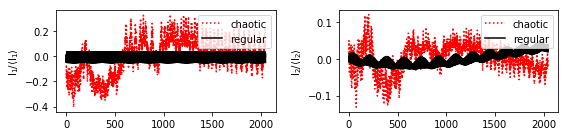

In [45]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(fort81Worst[:,1]/np.mean(fort81Worst[:,1])-1.0,'r:')
plt.plot(fort81Best [:,1]/np.mean(fort81Best [:,1])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.plot(fort81Worst[:,2]/np.mean(fort81Worst[:,2])-1.0,'r:')
plt.plot(fort81Best [:,2]/np.mean(fort81Best [:,2])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.legend(['chaotic','regular'],loc=1)

plt.tight_layout()
plt.savefig('Invariant.FB.'+str(dTune)+'.png',dpi=180)

# Lost Particles

In [46]:
print('===========================')
print('======= Lost Ptcls ========')
print('===========================')

In [47]:
TBTdata = TBTdataTmp[:,:,iLost]
X = TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:])
Y = TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:])
tune1 = np.zeros([2,nptLost])
tune2 = np.zeros([2,nptLost])
tune3 = np.zeros([2,nptLost])
for i in range(nptLost):
    tune1[0,i],amp = impact.util.naff(1,X[:nTurn,i],window_id=1)
    tune1[1,i],amp = impact.util.naff(1,Y[:nTurn,i],window_id=1)
    tune2[0,i],amp = impact.util.naff(1,X[nTurn:,i],window_id=1)
    tune2[1,i],amp = impact.util.naff(1,Y[nTurn:,i],window_id=1)
    tune3[0,i],amp = impact.util.naff(1,X[:,i],window_id=1)
    tune3[1,i],amp = impact.util.naff(1,Y[:,i],window_id=1)

In [48]:
Xdiff = np.abs(tune2[0,:]-tune1[0,:])
Ydiff = np.abs(tune2[1,:]-tune1[1,:])
Adiff = np.sqrt(Xdiff**2 + Ydiff**2)
print('max(Xdiff)',np.max(Xdiff))
print('max(Ydiff)',np.max(Ydiff))
print('max(Adiff)',np.max(Adiff))
Adiff = np.log(Adiff+1.0e-6)
Xdiff = np.log(Xdiff+1.0e-6)
Ydiff = np.log(Ydiff+1.0e-6)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

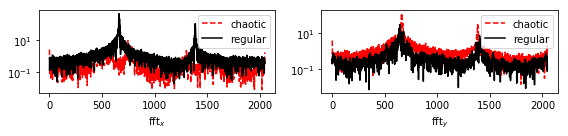

In [49]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.semilogy(np.abs(np.fft.fft(X[:,iMaxX])),'r--')
plt.semilogy(np.abs(np.fft.fft(X[:,iMinX])),'k')
plt.xlabel('fft$_x$')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[:,iMaxY])),'r--')
plt.semilogy(np.abs(np.fft.fft(Y[:,iMinY])),'k')
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('fft$_y$')
plt.tight_layout()
plt.savefig('FFT.Lost.'+str(dTune)+'.png',dpi=180)

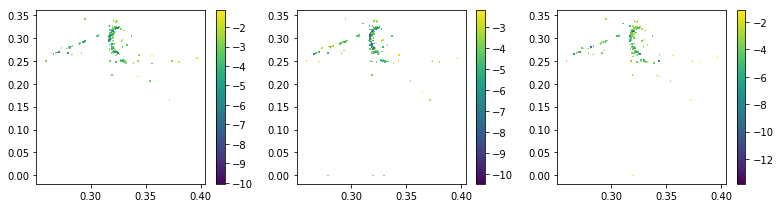

In [50]:
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(tune3[0,:],tune3[1,:],c=Adiff,s=0.2,marker='s')
plt.colorbar(f1)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.subplot(1,3,2)
f2=plt.scatter(tune3[0,:],tune3[1,:],c=Xdiff,s=0.2,marker='s')
plt.colorbar(f2)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.subplot(1,3,3)
f3=plt.scatter(tune3[0,:],tune3[1,:],c=Ydiff,s=0.2,marker='s')
plt.colorbar(f3)
# plt.xlim([0.22,0.5])
# plt.ylim([0.02,0.28])
plt.tight_layout()
plt.savefig('FMA.Lost.'+str(dTune)+'.png',dpi=180)

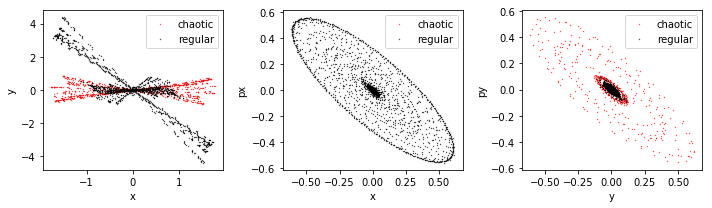

In [51]:
plt.figure(figsize=[10,3])
plt.subplot(1,3,1)
plt.scatter(TBTdata [:,0,iMaxA],TBTdata [:,2,iMaxA],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinA],TBTdata [:,2,iMinA],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
# plt.ylim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,2)
plt.scatter(TBTdata [:,0,iMaxX],TBTdata [:,1,iMaxX],c='r',s=0.1)
plt.scatter(TBTdata [:,0,iMinX],TBTdata [:,1,iMinX],c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['chaotic','regular'],loc=1)
# plt.xlim(-xmax*1.1,xmax*1.1)
plt.subplot(1,3,3)
plt.scatter(TBTdata [:,2,iMaxY],TBTdata [:,3,iMaxY],c='r',s=0.1)
plt.scatter(TBTdata [:,2,iMinY],TBTdata [:,3,iMinY],c='k',s=0.1)
plt.legend(['chaotic','regular'],loc=1)
plt.xlabel('y')
plt.ylabel('py')
plt.tight_layout()
plt.savefig('Poincare.Lost.'+str(dTune)+'.png',dpi=180)

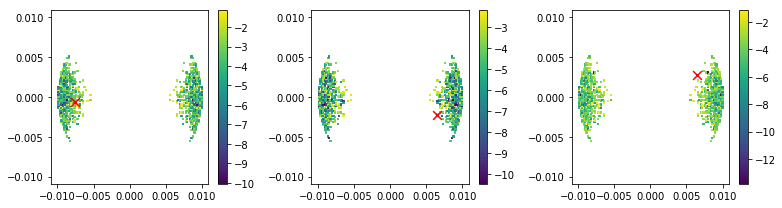

In [52]:
xmax = np.max([TBTdata[0,0,:],TBTdata[0,2,:]])
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
f1=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Adiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxA],TBTdata[0,2,iMaxA],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f1)
plt.subplot(1,3,2)
f2=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Xdiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxX],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f2)
plt.subplot(1,3,3)
f3=plt.scatter(TBTdata[0,0,:],TBTdata[0,2,:],c=Ydiff,s=1.6,marker='s')
plt.scatter(TBTdata[0,0,iMaxX],TBTdata[0,2,iMaxY],c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f3)
plt.tight_layout()
plt.savefig('DA.Lost.'+str(dTune)+'.png',dpi=180)

In [53]:
### Invariants Lost

In [54]:
pDataRegularWorst = np.zeros([1,9])
pDataRegularBest  = np.zeros([1,9])
pDataRegularWorst[0,:6] = TBTdata[0,:,iMaxA]
pDataRegularBest [0,:6] = TBTdata[0,:,iMinA]
pDataRegularWorst[0,6:] = pTest[0,6:]
pDataRegularBest [0,6:] = pTest[0,6:]

In [55]:
latticeI = copy(lattice)
latticeI.pop(1)
beamI = copy(beam)
beamI.nCore_y = 1
beamI.nCore_z = 1
beamI.n_particles = 1
impact.writeInputFile(beamI,latticeI) 
impact.writeParticleData(pDataRegularWorst, ke, mass, freq)
impact.run()
impact.writeParticleData(pDataRegularBest, ke, mass, freq)
fort81Worst = np.loadtxt('fort.81')
impact.run()
fort81Best = np.loadtxt('fort.81')

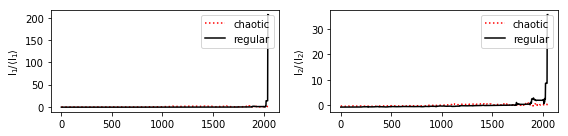

In [56]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(fort81Worst[:,1]/np.mean(fort81Worst[:,1])-1.0,'r:')
plt.plot(fort81Best [:,1]/np.mean(fort81Best [:,1])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.plot(fort81Worst[:,2]/np.mean(fort81Worst[:,2])-1.0,'r:')
plt.plot(fort81Best [:,2]/np.mean(fort81Best [:,2])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('Invariant.Lost.'+str(dTune)+'.png',dpi=180)

In [57]:
sys.stdout = old_stdout
log_file.close()